In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210520'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01, 10.54it/s]


(633403, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(630847, 20)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '영등포구'
target_dong = '영등포동2가'
target_purpose = '2종일반'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(24, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
570799,서울특별시 영등포구 영등포동2가 94-314,국회대로56길 33-1,두리하임,27.18,10.00,25000,8,2016.0,4.0,2020-07-09,919.793966,5.0,대,228.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가
602488,서울특별시 영등포구 영등포동2가 94-129,버드나루로7길 3,경동미르웰 여의도,14.03,5.11,16500,9,2017.0,3.0,2020-02-17,1176.051319,4.0,대,681.0,준주거지역,지정되지않음,상업용,평지,세로장방,소로각지,영등포구,영등포동2가
602490,서울특별시 영등포구 영등포동2가 321-2,영중로14길 35,더리버캐슬,45.26,13.35,43000,12,2017.0,3.0,2020-03-13,950.066284,4.0,대,158.3,준주거지역,지정되지않음,상업용,평지,사다리형,소로한면,영등포구,영등포동2가
602491,서울특별시 영등포구 영등포동2가 321-2,영중로14길 35,더리버캐슬,45.26,13.35,41000,10,2017.0,4.0,2021-01-19,905.877154,4.0,대,158.3,준주거지역,지정되지않음,상업용,평지,사다리형,소로한면,영등포구,영등포동2가
602493,서울특별시 영등포구 영등포동2가 284-3,영등포로51길 26-1,와이에이치빌리지(284-3),24.15,7.80,26350,9,2018.0,2.0,2020-11-27,1091.097308,3.0,대,271.1,준주거지역,지정되지않음,업무용,평지,사다리형,세로한면(가),영등포구,영등포동2가


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(24, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
570799,서울특별시 영등포구 영등포동2가 94-314,국회대로56길 33-1,두리하임,27.18,10.00,25000,8,2016.0,4.0,2020-07-09,919.793966,5.0,대,228.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가,988.677874,2021-03-01
602488,서울특별시 영등포구 영등포동2가 94-129,버드나루로7길 3,경동미르웰 여의도,14.03,5.11,16500,9,2017.0,3.0,2020-02-17,1176.051319,4.0,대,681.0,준주거지역,지정되지않음,상업용,평지,세로장방,소로각지,영등포구,영등포동2가,1318.771759,2021-03-01
602490,서울특별시 영등포구 영등포동2가 321-2,영중로14길 35,더리버캐슬,45.26,13.35,43000,12,2017.0,3.0,2020-03-13,950.066284,4.0,대,158.3,준주거지역,지정되지않음,상업용,평지,사다리형,소로한면,영등포구,영등포동2가,1073.505615,2021-03-01
602491,서울특별시 영등포구 영등포동2가 321-2,영중로14길 35,더리버캐슬,45.26,13.35,41000,10,2017.0,4.0,2021-01-19,905.877154,4.0,대,158.3,준주거지역,지정되지않음,상업용,평지,사다리형,소로한면,영등포구,영등포동2가,912.830613,2021-03-01
602493,서울특별시 영등포구 영등포동2가 284-3,영등포로51길 26-1,와이에이치빌리지(284-3),24.15,7.80,26350,9,2018.0,2.0,2020-11-27,1091.097308,3.0,대,271.1,준주거지역,지정되지않음,업무용,평지,사다리형,세로한면(가),영등포구,영등포동2가,1123.181562,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

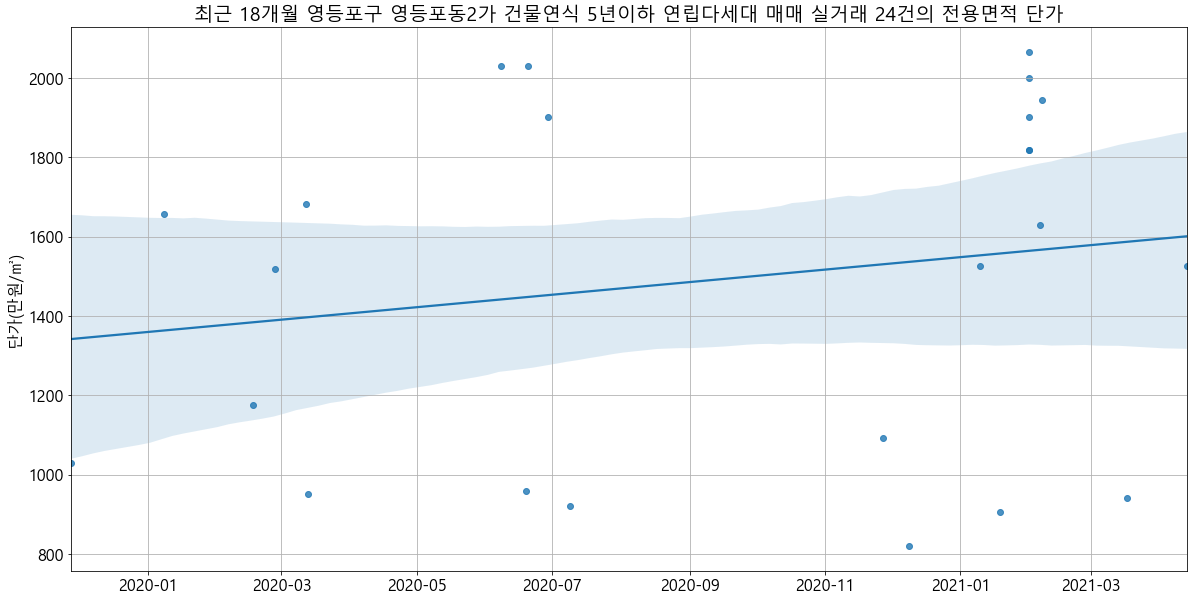

In [19]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [20]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

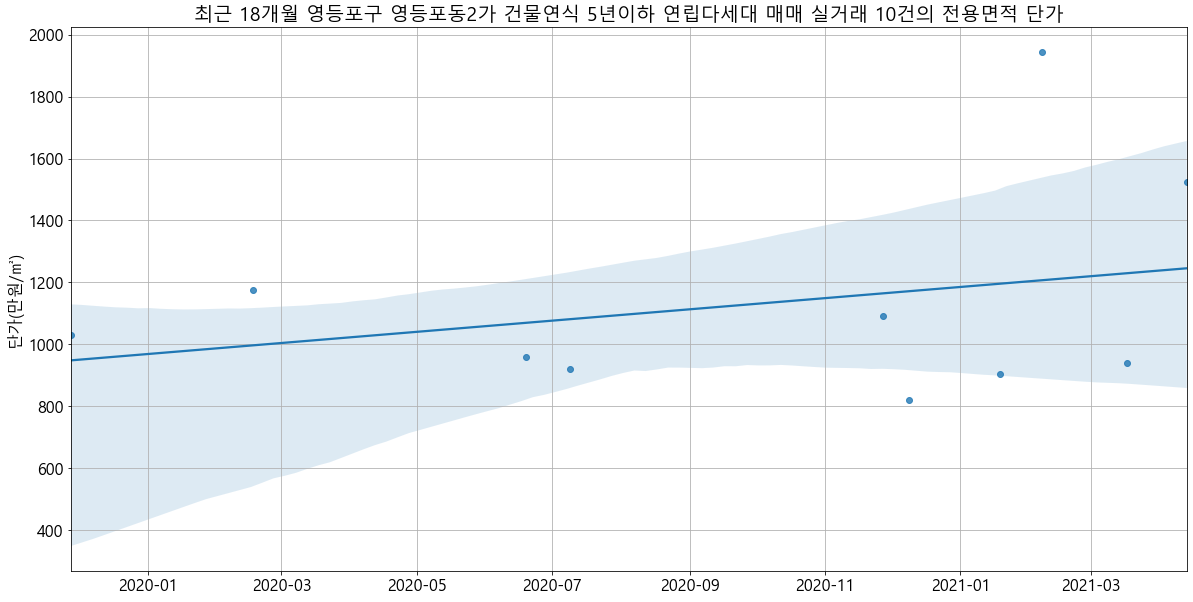

In [21]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [22]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [23]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(109, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
546977,서울특별시 영등포구 영등포동2가 28-118,국회대로54길 65-3,그린나래,36.10,11.95,23900,7,2014.0,1.0,2015-01-28,662.049861,7.0,대,549.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가
546978,서울특별시 영등포구 영등포동2가 28-118,국회대로54길 65-3,그린나래,36.63,12.12,28000,7,2014.0,2.0,2016-10-08,764.400764,7.0,대,549.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가
546979,서울특별시 영등포구 영등포동2가 28-118,국회대로54길 65-3,그린나래,36.63,12.12,27800,8,2014.0,2.0,2016-11-10,758.940759,7.0,대,549.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가
546980,서울특별시 영등포구 영등포동2가 28-118,국회대로54길 65-3,그린나래,36.10,11.95,27900,9,2014.0,3.0,2017-11-29,772.853186,7.0,대,549.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가
546981,서울특별시 영등포구 영등포동2가 28-118,국회대로54길 65-3,그린나래,34.52,11.43,27000,9,2014.0,3.0,2017-12-12,782.155272,7.0,대,549.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가


In [24]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'영등포구 영등포동2가 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 109건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

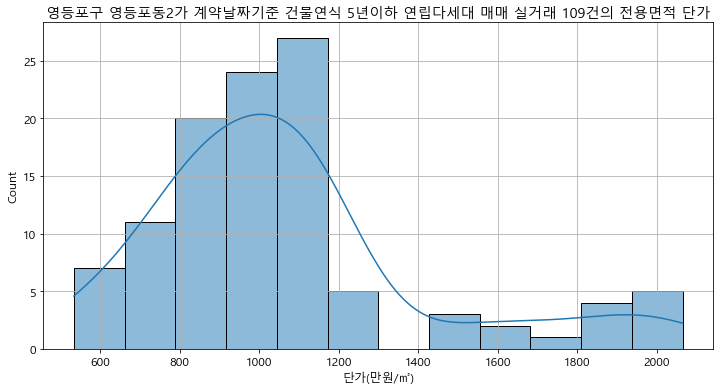

In [25]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [26]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [27]:
concat_df = pd.concat([target_df2])

In [28]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [29]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [30]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(43, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 영등포구 영등포동2가 238-0,영등포로53길 32,프리스틴,29.48,9.12,26900,7,2017.0,1.0,2018-02-03,912.483039,4.0,대,185.5,준주거지역,지정되지않음,상업기타,평지,사다리형,중로한면,영등포구,영등포동2가,1131.674463,2021-03-01,836.895857,1022.723992
1,서울특별시 영등포구 영등포동2가 238-0,영등포로53길 32,프리스틴,29.60,9.15,23900,7,2017.0,1.0,2018-02-03,807.432432,4.0,대,185.5,준주거지역,지정되지않음,상업기타,평지,사다리형,중로한면,영등포구,영등포동2가,1001.389204,2021-03-01,836.895857,1022.723992
2,서울특별시 영등포구 영등포동2가 238-0,영등포로53길 32,프리스틴,36.09,11.16,30300,9,2017.0,1.0,2018-09-03,839.567747,4.0,대,185.5,준주거지역,지정되지않음,상업기타,평지,사다리형,중로한면,영등포구,영등포동2가,989.813077,2021-03-01,836.895857,1022.723992
3,서울특별시 영등포구 영등포동2가 238-0,영등포로53길 32,프리스틴,38.32,11.85,30200,9,2017.0,1.0,2018-04-06,788.100209,4.0,대,185.5,준주거지역,지정되지않음,상업기타,평지,사다리형,중로한면,영등포구,영등포동2가,968.019225,2021-03-01,836.895857,1022.723992
4,서울특별시 영등포구 영등포동2가 28-105,국회대로54길 53-1,에코하임,29.53,8.03,29990,11,2018.0,1.0,2019-01-05,1015.577379,3.0,대,473.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가,1221.275516,2021-03-01,1015.577379,1221.275516


In [31]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(17, 26)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
3,서울특별시 영등포구 영등포동2가 238-0,영등포로53길 32,프리스틴,38.3200,11.85,30200,9,2017.0,1.0,2018-04-06,788.100209,4.0,대,185.5,준주거지역,지정되지않음,상업기타,평지,사다리형,중로한면,영등포구,영등포동2가,968.019225,2021-03-01,836.895857,1022.723992
4,서울특별시 영등포구 영등포동2가 28-105,국회대로54길 53-1,에코하임,29.5300,8.03,29990,11,2018.0,1.0,2019-01-05,1015.577379,3.0,대,473.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가,1221.275516,2021-03-01,1015.577379,1221.275516
8,서울특별시 영등포구 영등포동2가 28-116,버드나루로3길 11,더 위일 중마루,29.7300,5.30,27800,9,2018.0,1.0,2019-03-17,935.082408,3.0,대,420.0,준주거지역,지정되지않음,업무용,평지,부정형,소로각지,영등포구,영등포동2가,1114.396738,2021-03-01,1159.655693,1357.122723
12,서울특별시 영등포구 영등포동2가 28-118,국회대로54길 65-3,그린나래,36.6300,12.12,27800,8,2014.0,2.0,2016-11-10,758.940759,7.0,대,549.0,준주거지역,지정되지않음,상업기타,평지,세로장방,세로한면(가),영등포구,영등포동2가,995.368678,2021-03-01,757.003293,948.742633
13,서울특별시 영등포구 영등포동2가 28-120,국회대로56길 58,청람,29.8800,11.60,24500,9,2017.0,3.0,2020-12-09,819.946452,4.0,대,430.0,준주거지역,지정되지않음,상업기타,평지,가로장방,세로각지(가),영등포구,영등포동2가,837.040620,2021-03-01,819.946452,837.040620
15,서울특별시 영등포구 영등포동2가 284-3,영등포로51길 26-1,와이에이치빌리지(284-3),28.2400,9.12,26500,8,2018.0,0.0,2018-07-01,938.385269,3.0,대,271.1,준주거지역,지정되지않음,업무용,평지,사다리형,세로한면(가),영등포구,영등포동2가,1129.216907,2021-03-01,1014.741289,1126.199234
18,서울특별시 영등포구 영등포동2가 284-4,영등포로47길 16,루브르하우스,29.7500,11.61,28500,7,2018.0,2.0,2020-06-19,957.983193,3.0,대,472.1,준주거지역,지정되지않음,상업용,평지,사다리형,세로각지(가),영등포구,영등포동2가,1042.630851,2021-03-01,943.494522,1077.134248
26,서울특별시 영등포구 영등포동2가 299-0,영등포로49길 9-14,뜰아래,24.6092,9.52,25550,10,2017.0,2.0,2019-11-14,1038.229605,4.0,대,849.5,준주거지역,지정되지않음,업무용,평지,부정형,세로한면(가),영등포구,영등포동2가,1165.933101,2021-03-01,1100.154275,1235.474580
29,서울특별시 영등포구 영등포동2가 315-0,영등포로49길 9-15,더메종315,28.9400,8.58,29800,7,2019.0,0.0,2019-11-27,1029.716655,2.0,대,200.3,준주거지역,지정되지않음,상업기타,평지,정방형,세로한면(가),영등포구,영등포동2가,1156.373048,2021-03-01,1057.209037,1202.810780
30,서울특별시 영등포구 영등포동2가 321-2,영중로14길 35,더리버캐슬,45.2600,13.35,41000,10,2017.0,4.0,2021-01-19,905.877154,4.0,대,158.3,준주거지역,지정되지않음,상업용,평지,사다리형,소로한면,영등포구,영등포동2가,912.830613,2021-03-01,905.877154,912.830613


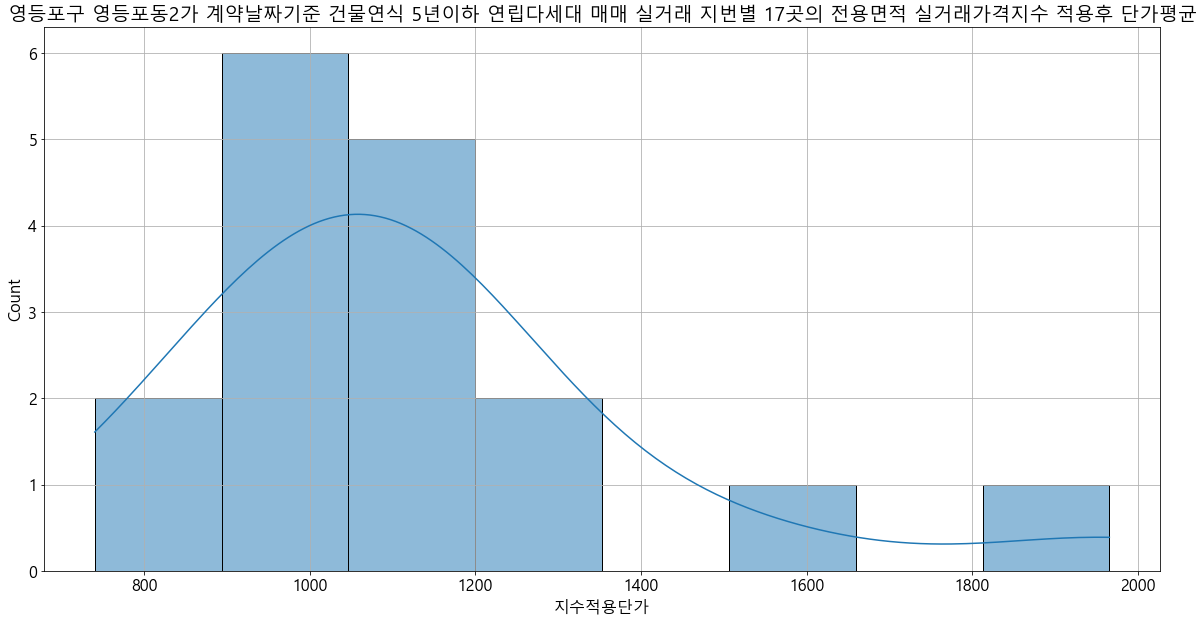

In [32]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [33]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [34]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1
0,서울특별시 영등포구 영등포동2가 238-0,프리스틴,2017.0,38.32,2018-04-06,788.100209,2021-03-01,968.019225,준주거지역
1,서울특별시 영등포구 영등포동2가 28-105,에코하임,2018.0,29.53,2019-01-05,1015.577379,2021-03-01,1221.275516,준주거지역
2,서울특별시 영등포구 영등포동2가 28-116,더 위일 중마루,2018.0,29.73,2019-03-17,935.082408,2021-03-01,1114.396738,준주거지역
3,서울특별시 영등포구 영등포동2가 28-118,그린나래,2014.0,36.63,2016-11-10,758.940759,2021-03-01,995.368678,준주거지역
4,서울특별시 영등포구 영등포동2가 28-120,청람,2017.0,29.88,2020-12-09,819.946452,2021-03-01,837.040620,준주거지역


In [35]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)